In [ ]:
#importujemy skladniki sieci

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
zip_path = '/content/drive/MyDrive/ResNet/Res.zip'
!cp {zip_path} .
!unzip -q Res.zip
!rm Res.zip

In [3]:
zip_path = '/content/drive/MyDrive/scripts.zip'
!cp {zip_path} .
!unzip -q scripts.zip
!rm scripts.zip

In [4]:
zip_path = '/content/drive/MyDrive/input10.zip'
!cp {zip_path} .
!unzip -q input10.zip
!rm input10.zip

In [5]:
zip_path = '/content/drive/MyDrive/output10.zip'
!cp {zip_path} .
!unzip -q output10.zip
!rm output10.zip

In [6]:
pip install --upgrade tf_slim

     |████████████████████████████████| 352 kB 9.1 MB/s 


In [ ]:
a = []
while(1):
    a.append('1')

In [7]:
import tf_slim as slim

In [8]:
import os
import time
import numpy as np
import tensorflow as tf

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
import tf_slim.layers as layers

In [11]:
import utils
import Block

In [12]:
import os

input_dir = "/content/input10"
target_dir = "/content/output10"
img_size = (160, 256)
num_classes = 20
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:290], target_img_paths[:290]):
    print(input_path, "|", target_path)

Number of samples: 297
/content/input10/10_1.png | /content/output10/10_1d.png
/content/input10/10_2.png | /content/output10/10_2d.png
/content/input10/10_3.png | /content/output10/10_3d.png
/content/input10/11_1.png | /content/output10/11_1d.png
/content/input10/11_2.png | /content/output10/11_2d.png
/content/input10/11_3.png | /content/output10/11_3d.png
/content/input10/12_1.png | /content/output10/12_1d.png
/content/input10/12_2.png | /content/output10/12_2d.png
/content/input10/12_3.png | /content/output10/12_3d.png
/content/input10/13_1.png | /content/output10/13_1d.png
/content/input10/13_2.png | /content/output10/13_2d.png
/content/input10/13_3.png | /content/output10/13_3d.png
/content/input10/14_1.png | /content/output10/14_1d.png
/content/input10/14_2.png | /content/output10/14_2d.png
/content/input10/14_3.png | /content/output10/14_3d.png
/content/input10/15_1.png | /content/output10/15_1d.png
/content/input10/15_2.png | /content/output10/15_2d.png
/content/input10/15_3.png

In [ ]:
# Teraz mamy inputy jako stringi

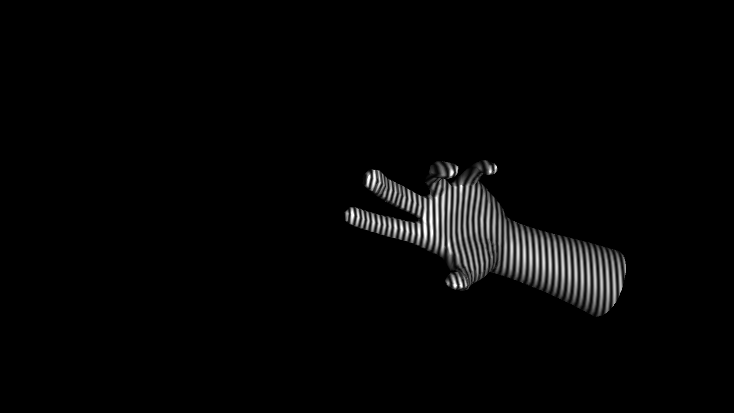

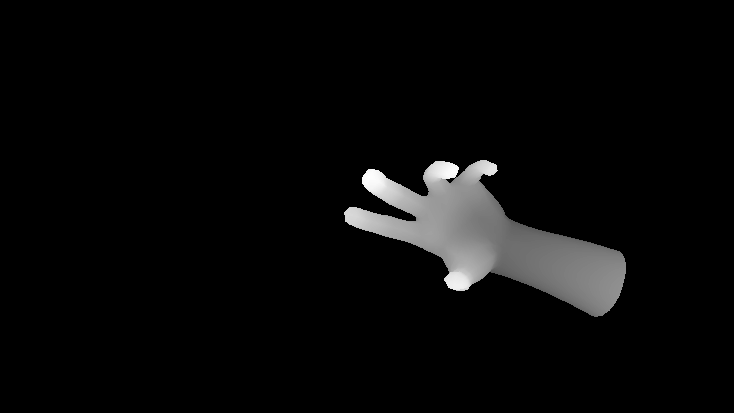

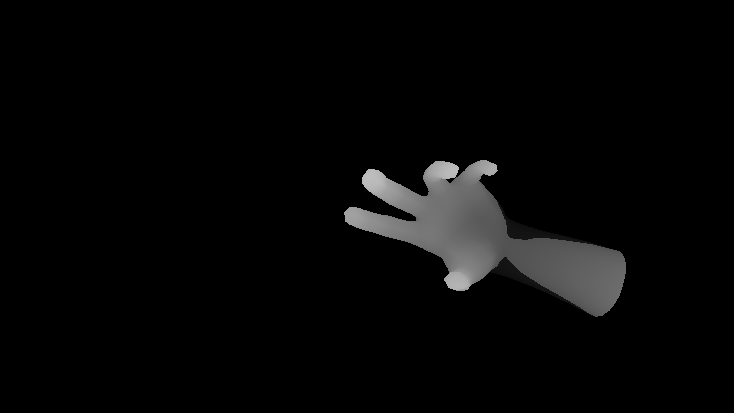

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import math
import numpy as np


# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

#img na x klas - test
img2 = load_img(target_img_paths[7])
img2 = PIL.ImageOps.grayscale(img2)
for i in range(img2.width):
  for j in range(img2.height):
    for c in range(num_classes):
      if ((img2.getpixel((i,j)) > (40+((c)*(80-40)/(num_classes)))) and (img2.getpixel((i,j)) <= (40+((c+1)*(80-40)/(num_classes))))):
        img2.putpixel( (i,j), (c+1) )
#img2 = img2*25
display(img2)

In [14]:
import random

# Split our img paths into a training and a validation set
val_samples = 64
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [15]:
# Step1 load MNITST data
# change to mat file
input_data = train_input_img_paths
output_data = train_target_img_paths
input_val_data = val_input_img_paths
output_val_data = val_target_img_paths

In [ ]:
#od tego miejsca w dół dodaje batchsize jako pierwszy wymiar tensowów in&out !!! to może sporo namieszać

In [16]:
tf.reset_default_graph()
batchsize = 6
x_in = tf.placeholder(tf.float32, shape=[batchsize,160,256,1],name='inputs')
x_out = tf.placeholder(tf.float32, shape=[batchsize,160,256,1], name='outputs')
code_length = 256
code = tf.placeholder(tf.float32, shape=[batchsize,code_length],name='code')

is_training = tf.placeholder(tf.bool, name='is_training')

In [ ]:
print(x_out.dtype)

<dtype: 'float32'>


In [17]:
import numpy as np
from tf_slim import dtypes
import cv2

img4=load_img(output_data[5],target_size=(160,256))
img4=PIL.ImageOps.grayscale(img4)
img3 = np.array(img4)
img3 = img3.astype(np.float32)
img3 = np.multiply(img3, 1.0 / 255.0)
print(img3[80,80])
#x_out = tf.reshape(
#        img3, 
#        [1, int(img4.height), 
#        int(img4.width), 1])
print(x_out.shape)

0.0
(6, 160, 256, 1)


In [18]:
# Reisudal blocks
encode_flag = True
odd_flags = None
net = x_in
blocks_en = [
    [(16, 8, 2)],
    [(32, 16, 2)],
]
for i, block in enumerate(blocks_en):
    print("index", i)
    block_params = utils.get_block(block, is_training=is_training)
    # build the net
    block_obj = Block.Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=encode_flag,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags = odd_flags
        )
    net, odd_flags = block_obj.get_block()
    print("note odd flags : ", odd_flags)
    

index 0
note odd flags :  [False]
index 1
note odd flags :  [False, False]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [19]:
# get shape of last block
encode_last_block_shape = net.get_shape()

In [20]:
# flatten layer
with tf.name_scope('flatten_en'):
    net = layers.flatten(net)
    tf.summary.histogram('flatten_en',net)
flatten_length = int(net.get_shape()[-1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:336: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [21]:
with tf.name_scope('encoder_layer'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=code_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('encode_layer',net)
    code = net

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
encode_last_block_shape[2]
print(odd_flags)

[False, False]


In [22]:
print(x_out.dtype)

<dtype: 'float32'>


In [23]:
with tf.name_scope('flatten_de'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=flatten_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('flatten_en', net)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [24]:
# flatten to convolve
with tf.name_scope('flatten_to_conv'):
    net = tf.reshape(
        net, 
        [batchsize, int(encode_last_block_shape[1]), 
         int(encode_last_block_shape[2]), int(encode_last_block_shape[3])])

In [ ]:
net.get_shape()

TensorShape([Dimension(20), Dimension(40), Dimension(64), Dimension(32)])

In [ ]:
x_out.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [25]:
# Residual blocks
blocks_de = [
     [(16, 16, 2)],
     [(1, 8, 2)],]
for i, block in enumerate(blocks_de):
    block_params = utils.get_block(block, is_training=is_training)
    # build the net
    
    block_obj = Block.Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=False,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags = odd_flags
    )
    net = block_obj.get_block()
#x_out = net

0   (6, 40, 64, 16)
1   (6, 80, 128, 16)
2   (6, 80, 128, 16)
(6, 80, 128, 16)
0   (6, 80, 128, 8)
1   (6, 160, 256, 8)
2   (6, 160, 256, 1)
(6, 160, 256, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
x_out.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [ ]:
print(x_out.dtype)

<dtype: 'float32'>


In [ ]:
x_in.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [ ]:
net.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [ ]:
img4=load_img(output_data[5],target_size=(160,256))
img4=PIL.ImageOps.grayscale(img4)
img3 = np.array(img4)
img3 = img3.astype(np.float32)
img3 = np.multiply(img3, 1.0 / 255.0)
print(img3[80,80])
#x_out = tf.reshape(
#        img3, 
#        [1, int(img4.height), 
#        int(img4.width), 1])

0.0


In [26]:
# loss function
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.square(net-x_out))
    print(cost)
    tf.summary.scalar('loss', cost)

Tensor("loss/Mean:0", shape=(), dtype=float32)


In [ ]:
x_in.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [ ]:
x_out.get_shape()

TensorShape([Dimension(20), Dimension(160), Dimension(256), Dimension(1)])

In [27]:
# learning rate
with tf.name_scope('learning_rate'):
    init_lr = tf.placeholder(tf.float32, name='LR')
    global_step = tf.placeholder(tf.float32, name="global_step")
    decay_step = tf.placeholder(tf.float32, name="decay_step")
    decay_rate = tf.placeholder(tf.float32, name="decay_rate")
    learning_rate = tf.train.exponential_decay(
        learning_rate = init_lr ,
        global_step = global_step,
        decay_steps = decay_step,
        decay_rate = decay_rate,
        staircase=False,
        name=None)   

In [ ]:
print(input_val_data[64])

IndexError: ignored

In [ ]:
imt = load_img(input_data[0],target_size=(160,256,3))
imt = PIL.ImageOps.grayscale(imt)
imt = np.array(imt)
imt = imt.astype(np.float32)
imt = np.multiply(imt, 1.0 / 255.0)

print(imt[110,210])


0.0


In [28]:
#nowa klasa, duzo zmian -> batche #2 !!!!!!!

import numpy as np
from tf_slim import dtypes
import cv2

class RAE():
  def __init__(self,
               train,
               batchnumber,
               images,
               batch_size,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    bn = batchnumber
    #imgcol = np.zeros((160,256,3))
    imgout1 = np.zeros((batchsize,160,256,1))
    imgout = np.zeros((batchsize,160,256,1))
    img = np.zeros((batchsize,160,256,1))
    #imgout1col = np.zeros((batchsize,160,256,3))

    for im in range(images):
      imrand = random.randrange(0,63)
      print(imrand)
      if train:
        imgcol=load_img(input_data[batch_size*bn+im],target_size=(160,256,3))
      else:
        imgcol=load_img(input_val_data[imrand],target_size=(160,256,3))
        print(input_val_data[imrand])
      #print(input_data[batch_size*bn+im])
      imgtemp = PIL.ImageOps.grayscale(imgcol)
      imgtemp = np.array(imgtemp)
      imgtemp = imgtemp.astype(np.float32)
      imgtemp = np.multiply(imgtemp, 1.0 / 255.0)
      imgtemp = np.expand_dims(imgtemp,axis=2)
      #print(imgtemp.shape)
      img[im] = imgtemp
      if train:
        imgout1col=load_img(output_data[batch_size*bn+im],target_size=(160,256,3))
      else:
        imgout1col=load_img(output_val_data[imrand],target_size=(160,256,3))
        print(output_val_data[imrand])
      #print(output_data[batch_size*bn+im])
      imgtemp2 = PIL.ImageOps.grayscale(imgout1col)
      imgtemp2 = np.array(imgtemp2)
      imgtemp2 = imgtemp2.astype(np.float32)
      imgtemp2 = np.multiply(imgtemp2, 1.0 / 255.0)
      imgtemp2 = np.expand_dims(imgtemp2,axis=2)
      imgout1[im] = imgtemp2
      #imgout[im] = np.array(imgout1[im])
      #imgout[im] = imgout[im].astype(np.float32)
      #imgout[im] = np.multiply(imgout[im], 1.0 / 255.0)
    #imgout = np.array(imgtemp2)
    imgout = imgout1.astype(np.float32)
    print("Koniec batcha: %d" % bn)
    #imgout = np.multiply(imgout, 1.0 / 255.0)
    img = np.array(img)
    #print(imgout.shape)
    x_out = tf.reshape(
        imgout, 
        [batchsize, int(imgcol.height), 
         int(imgcol.width), 1])
    #print(x_out.shape)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      self._num_examples = img.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        img = img.astype(np.float32)
        #img = np.multiply(img, 1.0 / 255.0)
    self._xout = imgout
    self._images = img
    self._epochs_completed = 0
    self._index_in_epoch = 0

  def nextbatch(self,batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= 200
    end = self._index_in_epoch
    #return self._images[start:end], self._labels
    return self._images[start:end], self._xout[start:end]

  def feed_dict(self,train,batch_size=6,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
      #xs ma 743 na 300 z jakiegos powodu
        xs,xout = raetrain.nextbatch(batch_size)   #moze byc tylko zadanie kolejnego batcha
        f_dict = {x_in: xs.reshape([batchsize,160,256,1]), x_out: xout.reshape([batchsize,160,256,1]),
                  is_training: True}
        #print(xs.shape)
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,xoutval = raeval.nextbatch(batch_size)
        print(x_val[0,80,100,0],xoutval[0,80,100,0])
        print(x_val[1,80,100,0],xoutval[1,80,100,0])
        print(x_val[2,80,100,0],xoutval[2,80,100,0])
        print(x_val[3,80,100,0],xoutval[3,80,100,0])
        print(x_val[4,80,100,0],xoutval[4,80,100,0])
        f_dict = {x_in: x_val.reshape([batchsize,160,256,1]), x_out: xoutval.reshape([batchsize,160,256,1]),  #takie powinno byc
                  is_training: False}
    return f_dict

In [ ]:
#nowa klasa, duzo zmian -> batche

import numpy as np
from tf_slim import dtypes
import cv2


class RAE():
  def __init__(self,
               train,
               images,
               batch_size,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    #imgcol = np.zeros((160,256,3))
    imgout1 = np.zeros((batchsize,160,256,1))
    imgout = np.zeros((batchsize,160,256,1))
    img = np.zeros((batchsize,160,256,1))
    #imgout1col = np.zeros((batchsize,160,256,3))

    for im in range(images):
      if train:
        imgcol=load_img(input_data[im],target_size=(160,256,3))
        print(input_data[im])
      else:
        imgcol=load_img(input_val_data[im],target_size=(160,256,3))
      print(input_data[im])
      imgtemp = PIL.ImageOps.grayscale(imgcol)
      imgtemp = np.array(imgtemp)
      imgtemp = imgtemp.astype(np.float32)
      imgtemp = np.multiply(imgtemp, 1.0 / 255.0)
      imgtemp = np.expand_dims(imgtemp,axis=2)
      #print(imgtemp.shape)
      img[im] = imgtemp
      imgout1col=load_img(output_data[im],target_size=(160,256,3))
      imgtemp2 = PIL.ImageOps.grayscale(imgout1col)
      imgtemp2 = np.array(imgtemp2)
      imgtemp2 = imgtemp2.astype(np.float32)
      imgtemp2 = np.multiply(imgtemp2, 1.0 / 255.0)
      imgtemp2 = np.expand_dims(imgtemp2,axis=2)
      imgout1[im] = imgtemp2
      imgout[im] = np.array(imgout1[im])
      imgout[im] = imgout[im].astype(np.float32)
      imgout[im] = np.multiply(imgout[im], 1.0 / 255.0)
    imgout = np.array(imgout1[im])
    img = np.array(img)
    #print(imgout.shape)
    #x_out = tf.reshape(
    #    imgout, 
    #    [batchsize, int(imgcol.height), 
    #     int(imgcol.width), 1])
    #print(x_out.shape)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      self._num_examples = img.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        img = img.astype(np.float32)
        img = np.multiply(img, 1.0 / 255.0)
    self._images = img
    self._epochs_completed = 0
    self._index_in_epoch = 0

  def nextbatch(self,batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= 200
    end = self._index_in_epoch
    #return self._images[start:end], self._labels
    return self._images[start:end]

  def feed_dict(self,train,batch_size=20,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
      #xs ma 743 na 300 z jakiegos powodu
        xs = raetrain.nextbatch(batch_size)   #moze byc tylko zadanie kolejnego batcha
        f_dict = {x_in: xs.reshape([batch_size,160,256,1]), 
                  is_training: True}
        #print(xs.shape)
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val = raeval.nextbatch(batch_size)
        f_dict = {x_in: x_val.reshape([batch_size,160,256,1]),  #takie powinno byc
                  is_training: False}
    return f_dict

In [ ]:
print(x_out.dtype)

<dtype: 'float32'>


In [ ]:
import numpy as np
from tf_slim import dtypes
import cv2



class RAE():
  def __init__(self,
               images,
               labels,
               batch_size,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    for im in range(images):
      img=load_img(input_data[im],target_size=(160,256))
      img=PIL.ImageOps.grayscale(img)
      #img = cv2.resize(img, dsize=(160, 256), interpolation=cv2.INTER_CUBIC)
    #print(img)
    img = np.array(img)
    labels = np.array(labels)
    dtype = dtypes.as_dtype(dtype).base_dtype
    #print(img.shape)
    #print(img)
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      self._num_examples = img.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        img = img.astype(np.float32)
        img = np.multiply(img, 1.0 / 255.0)
    self._images = img
    #print(self._images)
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  def nextbatch(self,batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
    #if self._index_in_epoch > 100:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      #self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= 200
    end = self._index_in_epoch

    #print(self._images)
    #print(self._labels)
    #print(self._images[1,1,2].shape)
    #print(self._images[2,2].shape)
    #print(self._images[3,].shape)
    #print(self._images[start:end].shape)
    #return self._images[start:end], self._labels
    return self._images, self._labels

  def feed_dict(self,train,batch_size=20,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
      #xs ma 743 na 300 z jakiegos powodu
        xs, _ = rae.nextbatch(batch_size)   #moze byc tylko zadanie kolejnego batcha
        #xtest,_ = rae.nextbatch(batch_size)
        #print(xtest.shape)
        #print(xs.shape)
        f_dict = {x_in: xs.reshape([20,160,256,1]), 
                  is_training: True}
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,_ = rae.nextbatch(batch_size)
        #f_dict = {x_in: xs.reshape([-1,743,200,3]), 
        f_dict = {x_in: x_val.reshape([20,160,256,1]),  #takie powinno byc
                  is_training: False}
    return f_dict

In [29]:
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.square(net-x_out))
    tf.summary.scalar('loss', cost)

In [30]:
# Train step 
# note: should add update_ops to the train graph
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

In [31]:
# Merge all the summaries and write to logdir
logdir = './log'
if not os.path.exists(logdir):
    os.mkdir(logdir)
merged = tf.summary.merge_all()
# Initialize the variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_writer = tf.summary.FileWriter(logdir + '/train',
                                      sess.graph)
val_writer = tf.summary.FileWriter(logdir + '/validation',
                                   sess.graph)

In [ ]:
print(x_out.dtype)

<dtype: 'float32'>


0.2392157


In [32]:
# Training the model by repeatedly running train_step
import time
import numpy as np 
epochs = 400
batch_size= 6
#num_batches = mnist.train.images.shape[0] // batchsize
num_batches = 10

lr_init = 0.001
d_rate = 0.9999

x_epoch = np.arange(0,epochs,1)
y_loss_trn = np.zeros(x_epoch.shape)
y_loss_val = np.zeros(x_epoch.shape)


#imgout1col=load_img(output_data[6],target_size=(160,256,3))
#imgtemp2 = PIL.ImageOps.grayscale(imgout1col)
#imgtemp2 = np.array(imgtemp2)
#imgtemp2 = imgtemp2.astype(np.float32)
#imgtemp2 = np.multiply(imgtemp2, 1.0 / 255.0)
#imgtemp2 = np.expand_dims(imgtemp2,axis=2)
#imgout1 = imgtemp2
#imgout = np.array(imgout1)
#imgout = imgout.astype(np.float32)
        #print(imgout.shape)
        #imgout = np.multiply(imgout, 1.0 / 255.0)
#x_out = tf.reshape(
#                imgout, 
#                [1, 160, 
#                256, 1])

# Init all variables
timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
print("[%s]: Epochs    Trn_loss    Val_loss" % (timestamp))
for i in range(epochs):
    lr_dict = {init_lr: lr_init, global_step:i,
               decay_step: i, decay_step: batch_size,
               decay_rate: d_rate}
    loss_trn_all = 0.0
    for b in range(num_batches):
        imgout1 = np.zeros((batchsize,160,256,1))
        imgout = np.zeros((batchsize,160,256,1))
        #print(imgout.shape)
        #imgout = np.multiply(imgout, 1.0 / 255.0)
        #x_out = tf.reshape(
        #        imgout, 
        #        [1, 160, 
        #        256, 1])
        #print(imgout[13,100,80,0])
        print(x_out.dtype)
        #print(x_out.shape)
        raetrain = RAE(True,b,batch_size,batch_size)
        train_dict = raetrain.feed_dict(True,lr_dict=lr_dict)
        #print(train_dict)
        # train
        summary_trn, _, loss_trn = sess.run(
            [merged, train_step, cost], 
            feed_dict=train_dict)
        loss_trn_all += loss_trn
    
    y_loss_trn[i] = loss_trn_all/num_batches
    train_writer.add_summary(summary_trn, i)
    # validation
    raeval = RAE(False,b,batch_size,batch_size)
    val_dict = raeval.feed_dict(False)
    summary_val, y_loss_val[i] = sess.run(
        [merged, cost],feed_dict=val_dict)
    val_writer.add_summary(summary_val, i)
    if i % 2 == 0:
        timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
        print('[%s]: %d    %.4f    %.4f' % (timestamp, i, 
                                            y_loss_trn[i], y_loss_val[i]))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
<dtype: 'float32'>
50
62
34
17
60
9
Koniec batcha: 2
<dtype: 'float32'>
8
26
7
21
4
9
Koniec batcha: 3
<dtype: 'float32'>
33
26
29
2
47
58
Koniec batcha: 4
<dtype: 'float32'>
33
0
52
27
27
24
Koniec batcha: 5
<dtype: 'float32'>
38
32
22
59
4
53
Koniec batcha: 6
<dtype: 'float32'>
9
22
3
23
10
24
Koniec batcha: 7
<dtype: 'float32'>
29
58
15
59
37
13
Koniec batcha: 8
<dtype: 'float32'>
27
20
47
5
25
23
Koniec batcha: 9
18
/content/input10/88_3.png
/content/output10/88_3d.png
40
/content/input10/81_2.png
/content/output10/81_2d.png
9
/content/input10/71_2.png
/content/output10/71_2d.png
49
/content/input10/20_1.png
/content/output10/20_1d.png
61
/content/input10/99_2.png
/content/output10/99_2d.png
61
/content/input10/99_2.png
/content/output10/99_2d.png
Koniec batcha: 9
0.4901961 0.4666667
0.0 0.0
0.0 0.0
0.2901961 0.654902
0.0 0.0
[2022-02-03: 21:21:38]: 352    0.0002    0.0016
<dtype: 'float32'>
44
2
38
7
59
14
Koniec bat

In [34]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

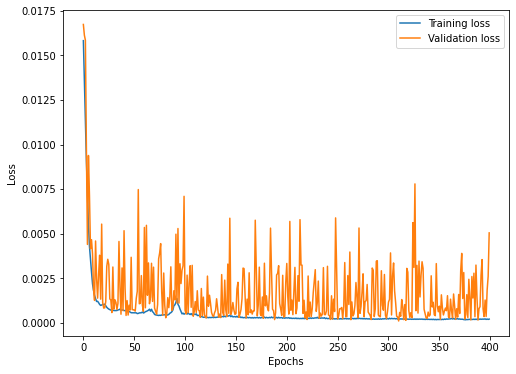

In [35]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_loss_trn)
plt.plot(x_epoch, y_loss_val)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [36]:
import pickle
data_dict = {
    "x_epoch": x_epoch,
    "y_loss_trn": y_loss_trn,
    "y_loss_val": y_loss_val,
}
with open("./result_resae13.pkl", 'wb') as fp:
    pickle.dump(data_dict, fp)

In [37]:
# test a image

img = np.zeros((batchsize,160,256,1))
img6 = np.zeros((batchsize,160,256,1))

for t in range(batch_size):
  
  imgt1 =load_img(input_data[170+t],target_size=(160,256))
  imgt1 = PIL.ImageOps.grayscale(imgt1)
  imgt1 = np.array(imgt1)
  imgt1 = imgt1.astype(np.float32)
  imgt1 = np.multiply(imgt1, 1.0 / 255.0)
  imgt1 = np.expand_dims(imgt1,axis=2)
  
  imgt2 = load_img(output_data[170+t],target_size=(160,256))
  imgt2 = PIL.ImageOps.grayscale(imgt2)
  imgt2 = np.array(imgt2)
  imgt2 = imgt2.astype(np.float32)
  imgt2 = np.multiply(imgt2, 1.0 / 255.0)
  imgt2 = np.expand_dims(imgt2,axis=2)
  
  img[t] = imgt1
  img6[t] = imgt2

In [38]:
img_est = sess.run(net, feed_dict={x_in: img, is_training: True})

In [ ]:
print(img_est[0,80,70,0])
print(img_est[1,80,70,0])
print(img_est[2,80,70,0])
print(img_est[3,80,70,0])
print(img6[3,80,70,0])
print(img6[2,80,70,0])
print(img6[1,80,70,0])
print(img6[0,80,70,0])
l = img6[0,80,70,0]+img6[1,80,70,0]+img6[2,80,70,0]+img6[3,80,70,0]+img6[4,80,70,0]+img6[5,80,70,0]
print(l/6)

-0.006045002
-0.005990197
0.4354027
0.0015321749
0.0
0.4235294461250305
0.0
0.0
0.07058824102083842


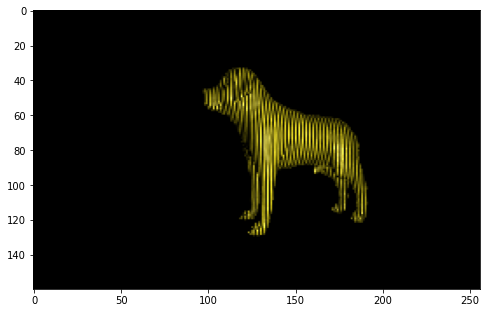

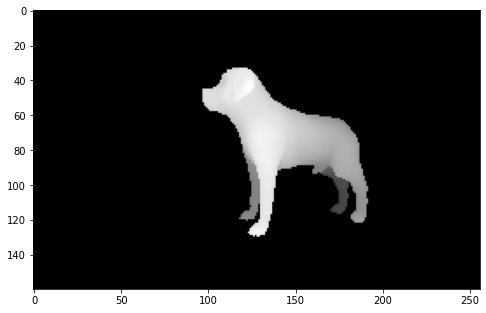

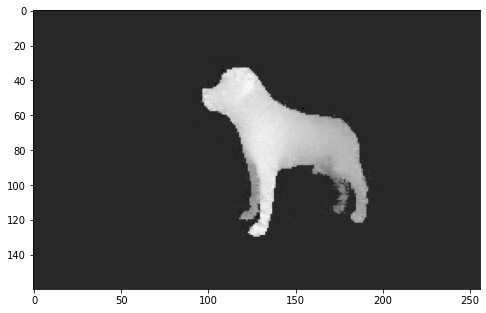

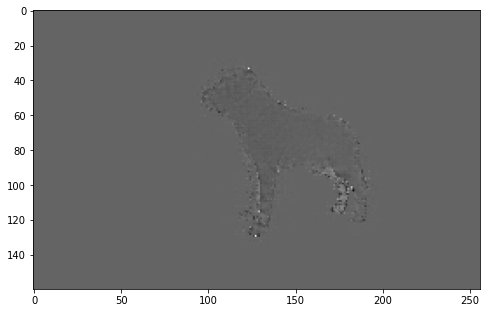

[-0.00083903 -0.0031749  -0.0043805  -0.00443012 -0.00443012]
-0.0011610038
0.0
-0.00039291516
0.0
0.0


In [39]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg


#image = mpimg.imread(img[5],)
q=5
d = 6
#print(img[:])
imgin=load_img(input_data[170+q],target_size=(160,256))
plt.imshow(imgin)
plt.show()
plt.imshow(np.reshape(img6[q], (160, 256)), cmap='gray')
plt.show()
plt.imshow(np.reshape(img_est[q], (160, 256)), cmap='gray')
plt.show()
plt.imshow(np.reshape(img_est[q]-img6[q], (160, 256)), cmap='gray')
plt.show()

print(img_est[0,100,100,0]-img_est[1:19,100,100,0])
print(img_est[3,d,100,0])
print(img6[3,d,100,0])
print(img_est[4,100,100,0])
print(img6[5,100,100,0])
print(img6[4,100,100,0])